In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import sys

from google.colab import drive
drive.mount('/content/drive')
PROJECT_ROOT = '/content/drive/My Drive/electricity'
%mkdir '/content/drive/My Drive/electricity' -p
%cd '/content/drive/My Drive/electricity'
DATASETS_PATH = "data"
WORKING_PATH = "."
%mkdir $DATASETS_PATH -p

LOGDIR = f"{WORKING_PATH}/logs"
MODEL_VERSION = 'TEST'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/electricity


## Download dataset

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1QuoP44tF5GFDkxXt7RCAZvOKWe4esO_D', dest_path=f"./{DATASETS_PATH}/Electricity-train.csv", unzip=False)
gdd.download_file_from_google_drive(file_id='1qD6w_s4SnNYYds67eAEq3j9PZs67bw-m', dest_path=f"./{DATASETS_PATH}/Electricity-test.csv", unzip=False)
gdd.download_file_from_google_drive(file_id='12WUb2S-mDpD8mgbPJrP0npTmGcoySRnx', dest_path=f"./{DATASETS_PATH}/MAPE.csv", unzip=False)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from typing import Dict, NamedTuple, Union
from tqdm.notebook import tqdm
import logging
from matplotlib import pyplot as plt
import time
from itertools import product
import gc
import pathlib
from glob import glob

from dateutil.relativedelta import relativedelta


In [ ]:

class Parameters(NamedTuple):
    split: int
    repeat: int
    epochs: int
    steps_per_epoch: int
    block_layers: int
    hidden_units: int
    num_blocks: int
    block_sharing: bool
    horizon: int
    history_lookback: int
    init_learning_rate: float
    decay_steps: int
    decay_rate: float
    loss: str
    pinball_tau: float
    batch_size: int
    weight_decay: float
    ts_sampling: str

hyperparams_dict = {
    "split": 0, # 0 is test split, 1 is validation split
    "repeat": list(range(0, 1024)),
    "epochs": 20,
    "steps_per_epoch": [50],
    "block_layers": [3],
    "hidden_units": 512,
    "num_blocks": 3,
    "block_sharing": True, # [True, False]
    "horizon": 12,
    "history_lookback": 1,
    "init_learning_rate": 1e-3,
    "decay_steps": 3,
    "decay_rate": 0.5,
    "loss": ["pinball", "pmape"], # ["pinball", "mape", "smape", "pmape"]
    "pinball_tau": [0.35], # This is selected to minimize the bias on the validation set
    "batch_size": 256,
    "weight_decay": 0,
    "ts_sampling": ["ts_weight"], # ["uniform", "ts_weight"]
}

HORIZON = 12

hyperparams = Parameters(**hyperparams_dict)

In [ ]:
class ElectricityLoader:
    def __init__(self, path="data/", split='train'):
        self.path = path
        self.split = split
        ts_raw = pd.read_csv(os.path.join(path,f'Electricity-{split}.csv')).iloc[:,1:].values.astype(np.float32)
        self.ts_raw = []

        for ts in ts_raw:
            self.ts_raw.append(ts[~np.isnan(ts)])

        self.ts_weight = np.zeros((len(self.ts_raw),), dtype=np.float32)
        for i,ts in enumerate(self.ts_raw):
            self.ts_weight[i] = len(ts)
        self.ts_weight = self.ts_weight / self.ts_weight.sum()

    def get_val_split(self, split_horizon=1):
        train_dataset = ElectricityLoader(path=self.path, split='train')
        test_dataset = ElectricityLoader(path=self.path, split='train')
        ts_raw = []
        for ts in train_dataset.ts_raw:
            ts_raw.append(ts[:-split_horizon*12])
        train_dataset.ts_raw = ts_raw
        ts_raw = []
        for ts in test_dataset.ts_raw:
            ts_raw.append(ts[-split_horizon*12:])
        test_dataset.ts_raw = ts_raw
        return train_dataset, test_dataset

    def get_batch(self, batch_size=64, win_len=14*2, horizon=12, ts_sampling='uniform'):
        target_ts = np.zeros((batch_size, horizon), dtype=np.float32)
        history_ts = np.zeros((batch_size, win_len), dtype=np.float32)

        if ts_sampling == "uniform":
            ts_idxs = np.random.choice(np.arange(len(self.ts_raw)), size=batch_size, replace=True)
        elif ts_sampling == "ts_weight":
            ts_idxs = np.random.choice(np.arange(len(self.ts_raw)), size=batch_size, replace=True, p=self.ts_weight)

        for i, ts_id in enumerate(ts_idxs):
            ts = self.ts_raw[ts_id]
            sampling_point = np.random.choice(np.arange(win_len, len(ts)-horizon+1), size=1, replace=False)[0]
            history_ts[i,:] = ts[sampling_point-win_len:sampling_point]
            target_ts[i,:] = ts[sampling_point:sampling_point+horizon]

        batch = {"history": history_ts, "target": target_ts}
        return batch


    def get_sequential_batch(self, win_len=14*2):
        history_ts = np.zeros((len(self.ts_raw), win_len), dtype=np.float32)
        for i, ts in enumerate(self.ts_raw):
            history_ts[i,:] = ts[-win_len:]
        return {"history": history_ts}


train_dataset = ElectricityLoader(path='data', split='train')
test_dataset = ElectricityLoader(path='data', split='test')

In [ ]:
# # Uncomment this cell to run in validation mode. This is a bit hacky, but fast to implement
# train_dataset, test_dataset = train_dataset.get_val_split(split_horizon=1)

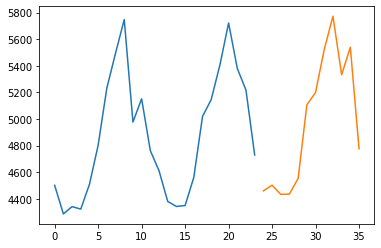

In [ ]:
batch = train_dataset.get_batch(win_len=12*2)

plt.plot(batch["history"][0])
plt.plot(np.concatenate([np.nan*np.zeros((24,)), batch["target"][0]]))

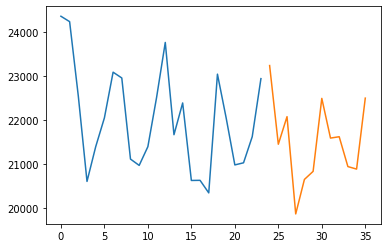

In [ ]:
batch = train_dataset.get_sequential_batch()
id = 10

plt.plot(train_dataset.ts_raw[id][-24:])
plt.plot(np.concatenate([np.nan*np.zeros((24,)), test_dataset.ts_raw[id]]))

In [ ]:
class NBeatsBlock(tf.keras.layers.Layer):
    def __init__(self, hyperparams: Parameters, input_size:int, output_size:int, **kw):
        super(NBeatsBlock, self).__init__(**kw)
        self.hyperparams = hyperparams
        self.input_size = input_size
        self.output_size = output_size
        self.fc_layers = []
        for i in range(hyperparams.block_layers):
            self.fc_layers.append(
                tf.keras.layers.Dense(hyperparams.hidden_units,
                                      activation=tf.nn.relu,
                                      kernel_regularizer=tf.keras.regularizers.l2(hyperparams.weight_decay),
                                      name=f"fc_{i}")
            )
        self.forecast = tf.keras.layers.Dense(output_size, activation=None, name="forecast")
        self.backcast = tf.keras.layers.Dense(self.input_size, activation=None, name="backcast")

    def call(self, inputs, training=False):
        h = self.fc_layers[0](inputs)
        for i in range(1, self.hyperparams.block_layers):
            h = self.fc_layers[i](h)
        backcast = tf.keras.activations.relu(inputs - self.backcast(h))

        return backcast, self.forecast(h)

In [ ]:
class NBeats:
    def __init__(self, hyperparams: Parameters, name: str='NBeats', logdir: str='logs', num_nodes: int = 100):
        super(NBeats, self).__init__()
        self.hyperparams = hyperparams
        self.name=name
        self.logdir=logdir
        self.num_nodes = num_nodes
        self.input_size = self.hyperparams.history_lookback*self.hyperparams.horizon

        self.nbeats_layers = []
        self.nbeats_layers.append(NBeatsBlock(hyperparams=hyperparams,
                                                  input_size=self.input_size,
                                                  output_size=hyperparams.horizon,
                                                  name=f"nbeats_{0}")
                                      )
        for i in range(1, hyperparams.num_blocks):
            if self.hyperparams.block_sharing:
                self.nbeats_layers.append(self.nbeats_layers[0])
            else:
                self.nbeats_layers.append(NBeatsBlock(hyperparams=hyperparams,
                                                    input_size=self.input_size,
                                                    output_size=hyperparams.horizon,
                                                    name=f"nbeats_{i}")
                                        )

        inputs, outputs = self.get_model()
        model = tf.keras.Model(inputs=inputs, outputs=outputs, name=name)
        self.inputs = inputs
        self.inputs = outputs
        self.model = model

    def get_model(self):
        history_in = tf.keras.layers.Input(shape=(self.hyperparams.history_lookback*self.hyperparams.horizon,), name='history')

        level = tf.reduce_max(history_in, axis=-1, keepdims=True)
        history_delevel = tf.math.divide_no_nan(history_in, level)

        backcast, forecast = self.nbeats_layers[0](inputs=history_delevel)
        for nb in self.nbeats_layers[1:]:
            backcast, forecast_layer = nb(inputs=backcast)
            forecast = forecast + forecast_layer

        forecast = forecast * level

        inputs = {'history': history_in}
        outputs = {'target': forecast}
        return inputs, outputs

    def forecast(self, train_dataset):
        input_data = train_dataset.get_sequential_batch(win_len=self.hyperparams.horizon*self.hyperparams.history_lookback)
        return self.model.predict({"history": input_data["history"]})['target']



In [ ]:
def smape(labels, preds):
    weights = tf.stop_gradient(
        tf.math.divide_no_nan(2.0, (tf.abs(preds) + tf.abs(labels))))
    return tf.reduce_mean(tf.abs(preds - labels) * weights)

def mape(labels, preds):
    weights = tf.math.divide_no_nan(1.0, tf.abs(labels))
    return tf.reduce_mean(tf.abs(preds - labels) * weights)

def get_pmape_loss(tau):
    def pmape_loss(labels, preds):
        weights = tf.math.divide_no_nan(1.0, tf.abs(labels))
        pinball = tf.where(labels > preds,
                           x=tau*(labels - preds),
                           y=(1-tau)*(preds-labels))
        return tf.reduce_mean(pinball * weights)
    return pmape_loss

def get_pinball_loss(tau):
    def pinball_loss(labels, preds):
        pinball = tf.where(labels > preds,
                           x=tau*(labels - preds),
                           y=(1-tau)*(preds-labels))
        return tf.reduce_mean(pinball)
    return pinball_loss

def mae(labels, preds):
    return tf.reduce_mean(tf.abs(preds - labels))


class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, train_dataset, test_dataset, hyperparams):
        super().__init__()
        self.input_data = train_dataset.get_sequential_batch(win_len=hyperparams.horizon*hyperparams.history_lookback)
        self.target = np.array(test_dataset.ts_raw)

    def on_train_begin(self, logs={}):
        pass

    def on_epoch_end(self, epoch, logs={}):
        prediction_test = self.model.predict({"history": self.input_data["history"]})
        logs['smape_test'] = smape(preds=prediction_test['target'], labels=self.target)
        logs['mape_test'] = mape(preds=prediction_test['target'], labels=self.target)

class Trainer:
    def __init__(self, hyperparams: Parameters, logdir: str):
        inp = dict(hyperparams._asdict())
        values = [v if isinstance(v, list) else [v] for v in inp.values()]
        self.hyperparams = [Parameters(**dict(zip(inp.keys(), v))) for v in product(*values)]
        inp_lists = {k: v  for k, v in inp.items() if isinstance(v, list)}
        values = [v for v in inp_lists.values()]
        variable_values = [dict(zip(inp_lists.keys(), v)) for v in product(*values)]
        folder_names = []
        for d in variable_values:
            folder_names.append(
                ';'.join(['%s=%s' % (key, value) for (key, value) in d.items()])
            )
        self.history = []
        self.forecasts = []
        self.models = []
        self.logdir = logdir
        self.folder_names = folder_names
        for i, h in enumerate(self.hyperparams):
            self.models.append(NBeats(hyperparams=h, name=f"nbeats_model_{i}",
                                      logdir=os.path.join(self.logdir, folder_names[i])))

    def generator(self, ds, hyperparams: Parameters):
        while True:
            batch = ds.get_batch(batch_size=hyperparams.batch_size,
                                 win_len=hyperparams.horizon*hyperparams.history_lookback,
                                 horizon=hyperparams.horizon,
                                 ts_sampling=hyperparams.ts_sampling)

            yield  {"history": batch["history"]}, {"target": batch["target"]}

    def save_forecast(self, forecast: np.ndarray, filename: str = "forecast.npy"):
        np.save(f"{WORKING_PATH}/{filename}", forecast)

    def fit(self, train_dataset, test_dataset, verbose=1):
        for i, hyperparams in enumerate(self.hyperparams):
            if verbose > 0:
                print(f"Fitting model {i+1} out of {len(self.hyperparams)}, {self.folder_names[i]}")

            path = f"results/{MODEL_VERSION}_split{self.models[i].hyperparams.split}/"
            pathlib.Path(f"{WORKING_PATH}/{path}").mkdir(parents=True, exist_ok=True)
            filename = os.path.join(path, self.folder_names[i]+'.npy')
            if os.path.exists(f"{WORKING_PATH}/{filename}"):
                continue

            boundary_step = hyperparams.epochs // 10
            boundary_start = hyperparams.epochs - boundary_step*hyperparams.decay_steps - 1

            boundaries = list(range(boundary_start, hyperparams.epochs, boundary_step))
            values = list(hyperparams.init_learning_rate * hyperparams.decay_rate ** np.arange(0, len(boundaries)+1))
            scheduler = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=boundaries, values=values)

            lr = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

            metrics = MetricsCallback(train_dataset=train_dataset, test_dataset=test_dataset, hyperparams=hyperparams)
            # tb = tf.keras.callbacks.TensorBoard(log_dir=self.models[i].logdir, embeddings_freq=10)

            if hyperparams.loss == 'smape':
                loss = smape
            elif hyperparams.loss == 'mape':
                loss = mape
            elif hyperparams.loss == 'mae':
                loss = mae
            elif hyperparams.loss == 'pmape':
                loss = get_pmape_loss(hyperparams.pinball_tau)
            elif hyperparams.loss == 'pinball':
                loss = get_pinball_loss(hyperparams.pinball_tau)

            self.models[i].model.compile(optimizer=tf.keras.optimizers.Adam(),
                                         loss=loss)

            fit_output = self.models[i].model.fit(self.generator(ds=train_dataset, hyperparams=hyperparams),
                                            callbacks=[lr, metrics], # tb
                                            epochs=hyperparams.epochs,
                                            steps_per_epoch=hyperparams.steps_per_epoch,
                                            verbose=verbose)
            self.history.append(fit_output.history)

            model_forecast = self.models[i].forecast(train_dataset)
            self.save_forecast(forecast=model_forecast, filename=filename)


In [ ]:
trainer = Trainer(hyperparams=hyperparams, logdir=LOGDIR)
trainer.fit(train_dataset=train_dataset, test_dataset=test_dataset)

Fitting model 1 out of 2048, repeat=0;steps_per_epoch=50;block_layers=3;loss=pinball;pinball_tau=0.35;ts_sampling=ts_weight
Fitting model 2 out of 2048, repeat=0;steps_per_epoch=50;block_layers=3;loss=pmape;pinball_tau=0.35;ts_sampling=ts_weight
Fitting model 3 out of 2048, repeat=1;steps_per_epoch=50;block_layers=3;loss=pinball;pinball_tau=0.35;ts_sampling=ts_weight
Fitting model 4 out of 2048, repeat=1;steps_per_epoch=50;block_layers=3;loss=pmape;pinball_tau=0.35;ts_sampling=ts_weight
Fitting model 5 out of 2048, repeat=2;steps_per_epoch=50;block_layers=3;loss=pinball;pinball_tau=0.35;ts_sampling=ts_weight
Fitting model 6 out of 2048, repeat=2;steps_per_epoch=50;block_layers=3;loss=pmape;pinball_tau=0.35;ts_sampling=ts_weight
Fitting model 7 out of 2048, repeat=3;steps_per_epoch=50;block_layers=3;loss=pinball;pinball_tau=0.35;ts_sampling=ts_weight
Fitting model 8 out of 2048, repeat=3;steps_per_epoch=50;block_layers=3;loss=pmape;pinball_tau=0.35;ts_sampling=ts_weight
Fitting model 9 

In [ ]:
def get_forecasts(path, filt):
    a = []
    for f in tqdm(glob(os.path.join(WORKING_PATH, path, filt))):
        df = np.load(f)
        a.append(df)
    return a


def get_ensemble(forecasts):
    return np.mean(np.stack(forecasts, axis=-1), axis=-1)


def get_metrics(preds, labels):
    metrics = {}
    metrics["smape"] = 100*smape(preds=preds, labels=labels).numpy()
    metrics["mape"] = 100*mape(preds=preds, labels=labels).numpy()
    pe = 100*(preds-labels)/labels
    metrics["pe_mean"] = np.mean(pe)
    metrics["pe_median"] = np.median(pe)
    return metrics


def get_stats(samples=10, ensemble_size=64, test_dataset=None, config_filt=None, path=None):
    files = glob(os.path.join(WORKING_PATH, path, filt))
    all_repeats = set([int(f.split(os.sep)[-1].split(";")[0].split("=")[-1]) for f in files])
    preds = np.array(get_forecasts(path=path, filt=config_filt+".npy"))

    metric_samples = []
    ensemble_samples = []
    for s in range(samples):
        ensemble_repeats = np.random.choice(list(all_repeats), size=ensemble_size, replace=False)
        ensemble = preds[ensemble_repeats].mean(axis=0)
        metric_samples.append(get_metrics(preds=ensemble, labels=test_dataset.ts_raw))
        ensemble_samples.append(ensemble)

    return pd.DataFrame(metric_samples), ensemble_samples


def save_ensemble_files(path, ensembles):
    pathlib.Path(f"{WORKING_PATH}/{path}").mkdir(parents=True, exist_ok=True)
    for i, e in enumerate(ensembles):
        filename = os.path.join(path, f"{i}.csv")
        df = pd.DataFrame(data=e, columns=[f"V{i+1}" for i in range(12)], index=[f"P{i+1}" for i in range(35)])
        df.to_csv(filename)

In [ ]:
MODEL_VERSION = "TEST"
split=0
path = f"results/{MODEL_VERSION}_split{split}/"
filt = "*repeat=*steps_per_epoch=50*block_layers=3*loss=pmape*pinball_tau=0.35;ts_sampling=ts_weight*"

forecasts = get_forecasts(path, filt)
a = get_ensemble(forecasts)

print("SMAPE:", 100*smape(preds=a, labels=test_dataset.ts_raw).numpy())
print("MAPE:", 100*mape(preds=a, labels=test_dataset.ts_raw).numpy())


SMAPE: 3.7425976246595383
MAPE: 3.7774112075567245


In [ ]:
ensemble_size = 64

pinball_filt = "*steps_per_epoch=50*block_layers=3*loss=pinball*pinball_tau=0.35;ts_sampling=ts_weight*"
metrics_pinball, ensembles_pinball = get_stats(samples=100, ensemble_size=ensemble_size,
                                               path=f"results/{MODEL_VERSION}_split{split}/",
                                               test_dataset=test_dataset,
                                               config_filt=pinball_filt)

print(f"PINBALL loss bootstrap stats, ensemble of {ensemble_size} sampled without replacement from 1024 models")
print(metrics_pinball.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]))

# Save ensemble files
path = f"results/{MODEL_VERSION}_split{hyperparams.split}/ensemble_{pinball_filt}"
save_ensemble_files(path=path, ensembles=ensembles_pinball)



PINBALL loss bootstrap stats, ensemble of 64 sampled without replacement from 1024 models
            smape        mape     pe_mean   pe_median
count  100.000000  100.000000  100.000000  100.000000
mean     3.829749    3.999312    0.798119    0.350924
std      0.016225    0.022732    0.039528    0.039218
min      3.798525    3.954580    0.695214    0.258462
5%       3.806607    3.967484    0.739715    0.280214
25%      3.817831    3.982693    0.772300    0.323148
50%      3.828459    3.996948    0.795330    0.352630
75%      3.839578    4.014520    0.827410    0.377261
95%      3.857330    4.039002    0.857155    0.409430
max      3.873867    4.061039    0.904122    0.437031


In [ ]:
pmape_filt = "*steps_per_epoch=50*block_layers=3*loss=pmape*pinball_tau=0.35;ts_sampling=ts_weight*"
metrics_pmape, ensembles_pmape = get_stats(samples=100, ensemble_size=ensemble_size,
                                           path=f"results/{MODEL_VERSION}_split{split}/",
                                           test_dataset=test_dataset,
                                           config_filt=pmape_filt)

print(f"PMAPE loss bootstrap stats, ensemble of {ensemble_size} sampled without replacement from 1024 models")
print(metrics_pmape.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]))

# Save ensemble files
path = f"results/{MODEL_VERSION}_split{hyperparams.split}/ensemble_{pmape_filt}"
save_ensemble_files(path=path, ensembles=ensembles_pmape)


PMAPE loss bootstrap stats, ensemble of 64 sampled without replacement from 1024 models
            smape        mape     pe_mean   pe_median
count  100.000000  100.000000  100.000000  100.000000
mean     3.738733    3.772845    0.329743    0.402183
std      0.022298    0.028228    0.049219    0.044265
min      3.661800    3.676698    0.184482    0.318068
5%       3.703522    3.730331    0.255808    0.328515
25%      3.724515    3.751092    0.300777    0.369744
50%      3.741779    3.777197    0.331295    0.405079
75%      3.754513    3.793392    0.365547    0.430145
95%      3.769735    3.812409    0.408684    0.476512
max      3.784157    3.832095    0.442383    0.509950


In [ ]:
# df = pd.DataFrame(data=a, columns=[f"V{i+1}" for i in range(12)], index=[f"P{i+1}" for i in range(35)])
# df.to_csv(os.path.join(path, "nbeats.csv"))

In [ ]:
# df_test = pd.read_csv(os.path.join('data',f'Electricity-test.csv'))
# df_nbeats = pd.read_csv(os.path.join(path, "nbeats.csv"))
# print("MAPE from file:", 100*mape(preds=df_nbeats.values[:,1:].astype(np.float32), labels=df_test.values[:,1:].astype(np.float32)).numpy())

In [ ]:
# np.mean(100*(a-test_dataset.ts_raw)/test_dataset.ts_raw)
# np.std(100*(a-test_dataset.ts_raw)/test_dataset.ts_raw)
# np.median(100*(a-test_dataset.ts_raw)/test_dataset.ts_raw)
# np.median(100*np.abs(a-test_dataset.ts_raw)/test_dataset.ts_raw)

In [ ]:
# np.sqrt(np.mean((a-test_dataset.ts_raw)*(a-test_dataset.ts_raw)))

In [ ]:
# naive = np.zeros((35,12), dtype=np.float32)
# for i,ts in enumerate(train_dataset.ts_raw):
#     naive[i,:] = ts[-hyperparams.horizon:]

# print("Naive MAPE:", 100*mape(preds=naive, labels=test_dataset.ts_raw).numpy())
# print("Naive RMSE:", np.sqrt(np.mean((naive-test_dataset.ts_raw)*(naive-test_dataset.ts_raw))))

In [ ]:
print("MAPE:", 100*mape(preds=a, labels=test_dataset.ts_raw).numpy())

MAPE: 3.7774112075567245


In [ ]:
weights = 1 / np.abs(test_dataset.ts_raw)
data = 100*(np.abs(a - test_dataset.ts_raw) * weights).ravel()

In [ ]:
data.std()

5.207637

Statistical analysis of errors

In [ ]:
import statsmodels.stats.api as sms
from scipy import stats

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
ape = pd.read_csv("data/MAPE.csv", header=None)

In [ ]:
data = ape.iloc[9,:] - ape.iloc[-1,:]

In [ ]:
data.mean()

0.7013778976190467

In [ ]:
def bootstrap_interval(data, alpha=0.05, sample_size=1000):
    samples = []
    for i in range(sample_size):
        idxs = np.random.choice(np.arange(len(data)), size=len(data), replace=True)
        samples.append(data[idxs].mean())
    samples = np.array(samples)
    return (np.quantile(samples, q=alpha), np.quantile(samples, q=1.0-alpha)), samples

q, samples = bootstrap_interval(data, alpha=0.01, sample_size=10000)
q

(0.16853121176190458, 1.3885109778571434)

In [ ]:
import tensorflow as tf

class NBEATSBlock(tf.keras.layers.Layer):
    def __init__(self, input_size: int, output_size: int, block_layers: int, hidden_units: int):
        super().__init__()
        self.fc_layers = []
        for i in range(block_layers):
            self.fc_layers.append(tf.keras.layers.Dense(hidden_units,
                                                        activation=tf.nn.relu))
        self.forecast = tf.keras.layers.Dense(output_size, activation=None)
        self.backcast = tf.keras.layers.Dense(input_size, activation=None)

    def call(self, x):
        inputs = x
        for layer in self.fc_layers:
            x = layer(x)
        backcast = tf.keras.activations.relu(inputs - self.backcast(x))
        return backcast, self.forecast(x)


class NBEATS(tf.keras.layers.Layer):
    def __init__(self, input_size: int, output_size: int, block_layers: int, hidden_units: int,
                 num_blocks: int, block_sharing: bool):
        super().__init__()
        self.blocks = [NBEATSBlock(input_size=input_size, output_size=output_size,
                                   block_layers=block_layers, hidden_units=hidden_units)]
        for i in range(1, num_blocks):
            if block_sharing:
                self.blocks.append(self.blocks[0])
            else:
                self.blocks.append(NBEATSBlock(input_size=input_size, output_size=output_size,
                                               block_layers=block_layers, hidden_units=hidden_units))

    def call(self, x):
        level = tf.reduce_max(x, axis=-1, keepdims=True)
        backcast = tf.math.divide_no_nan(x, level)
        forecast = 0.0
        for block in self.blocks:
            backcast, forecast_block = block(backcast)
            forecast = forecast + forecast_block
        return forecast * level

nbeats = NBEATS(input_size=12, output_size=12, block_layers=3, num_blocks=3, hidden_units=512, block_sharing=True)
inputs = tf.random.normal([256,12])
forecast = nbeats(inputs)

